<a href="https://colab.research.google.com/github/JikMyle/Civil-Service-Exam-Reviewer-Generator/blob/main/CSE_Reviewer_Dataset_Prep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preparation
Before fine-tuning an Pre-trained Large Language Model (PLLM), we first need
to prepare a sufficient large dataset relevant to the our study's objective:

To generate personalized Philippine Civil Service Examination (CSE) reviewer
questionnaires.

The dataset we aim to prepare will contain questions, answers, and subject
categories gathered from existing CSE reviewers available from various sources in a PDF format.

In [2]:
!pip install -q -U google-generativeai
!pip install pypdf
!pip install paginate_pandas

import google.generativeai as genai
from google.colab import userdata
from pypdf import PdfReader
from pathlib import Path
from tqdm.notebook import tqdm
from time import sleep
import re
import pandas as pd
from paginate_pandas import paginate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.7/300.7 kB 10.7 MB/s eta 0:00:00


#Data Extraction

In extracting the questions needed for the dataset, we use two tools:

**Pypdf** - for converting the reviewers from PDF to string sequences<br>
<b>Google's Gemini 1.5-flash</b> - for prompting-based question extraction

In [ ]:
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))
model = genai.GenerativeModel("gemini-1.5-flash")

In extracting the text from the PDF files, text per 8 pages are concatenated together and added to a list.

A request for question extraction will be sent to the AI for each item in the list. This is to bypass the AI model's input token limit by sending multiple smaller requests instead of a single large one.

In [ ]:
def fetch_all_pdf_from_path(path: str):
  """
  Fetches paths of all pdf files found in a given path.

  Args:
      path (str): The path to the directory containing the PDF files.

  Returns:
      list: A list of paths to the PDF files found in the given path.
  """

  pdf_list = []
  for file in Path(path).glob('*.pdf'):
    pdf_list.append(file.as_posix())
  return pdf_list

def extract_pdf_text_to_list(pdf_path: str, text_sequence_list: list):
  """
  Extracts the text from a PDF file and appends it to a list,
  wherein each list item contains text from at most 8 pages.

  Args:
      pdf_path (str): The path to the PDF file.
      text_sequence_list (list): A list to which the extracted text will be appended.

  Returns:
    list: The updated list containing the extracted text.
  """
  reader = PdfReader(pdf_path)
  text_sequence = ''

  page_limit = 8

  page_count = 0
  for page in reader.pages:
    page_text = page.extract_text()
    text_sequence += page_text + '\n'

    page_count += 1
    if page_count % page_limit == 0 or page_count == len(reader.pages):
      text_sequence_list.append(text_sequence)
      text_sequence = ''

  print(f"Text successfully extracted from {pdf_path}")
  return text_sequence_list


Run this code to see what pdf files are found the in directory

In [ ]:
pdf_directory = '/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources'
pdf_list = fetch_all_pdf_from_path(pdf_directory)

for pdf in pdf_list:
  print(pdf)

/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/CSE Complete Reviewer 2020.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/Civil-Service-Exam-Reviewer-for-Professional-and-Sub-Professional-Levels-2025.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/CSE REVIEWER 2025.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/EXCELSIO INSTITUTE CSE REVIEW PRO&SUB.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/DOCANS~4.DOC.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/DOCANS~1.DOC.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/phil-consti-20-QnA.docx.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/Verbal Reasoning (English Vocabulary Part 2).docx.pdf
/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/Verbal Reasoning (Engli

The code below will extract the text inside the pdf files and insert them all into a list.

In [ ]:
pdf_directory = '/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources'
pdf_list = fetch_all_pdf_from_path(pdf_directory)

text_sequence_list = []

for pdf in pdf_list:
  text_sequence_list = extract_pdf_text_to_list(pdf, text_sequence_list)


Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/CSE Complete Reviewer 2020.pdf
Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/Civil-Service-Exam-Reviewer-for-Professional-and-Sub-Professional-Levels-2025.pdf
Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/CSE REVIEWER 2025.pdf
Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/EXCELSIO INSTITUTE CSE REVIEW PRO&SUB.pdf
Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/DOCANS~4.DOC.pdf
Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/DOCANS~1.DOC.pdf
Text successfully extracted from /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/sources/phil-consti-20-QnA.docx.pd

For the model -- Gemini -- to properly extract the questions,
we defined a set of guidelines for it follow to ensure that the data
follows a uniform format.

The guidelines will be increased to improve how the model will handle certain situations during extraction.

In [ ]:
def extract_questions_from_text(text_sequence: str):
  """
  Extracts multiple-choice questions from a string sequence and returns
  them in a CSV format.

  Arguments:
      text_sequence (str): The string sequence containing the text.

  Return:
      str: The extracted questions in a CSV format.
  """

  extraction_prompt = f'''
    Extract questions from the text sequence and convert them into following format:
    id, question, option a, option b, option c, option d, option e, correct answer, subject

    Follow the guidelines below in extracting the questions and preparing the csv:
    1) The term questions or items may be used interchangeably in the guidelines.
    2) Exclude question that ask for demographic and personal information of the individual
        taking the examination.
    3) Exclude items that are not in the English language.
    4) If a question or answer option is multi-line, convert it into a single-line sequence
        and with the appropriate spacing if it consists of multiple sentence.
    5) If a question has fewer choices than in the format, write "none" in the respective position.
        **Ensure that all option columns (a to f) have a value, even if it is "none."**
    6) A question may not always use the letters (a-z) in denoting the answer options,
        it may sometimes use number (1-9).
    7) Do not rephrase, paraphrase, or change the item/s or question/s unless specified
        by the guidelines.
    8) The "correct answer" should contain only the letter of the correct option.
    9) In the "subject" column, you must identify in which of the following subjects
        the question belongs to:
          - Basic Operations
          - Word Problems
          - Word Association
          - Identifying Assumptions and Conclusions
          - Logic
          - Data Interpretation
          - Filing
          - Spelling
          - Grammar and Correct Usage
          - Vocabulary
          - Paragraph Organization
          - Reading Comprehension
          - Philippine Constitution
          - Code of Conduct And Ethical Standards for Public Officials and Employees
          - Peace and Human Rights Issues and Concepts
          - Environment Management and Protection
    10) If an item is about paragraph organization, consider the group of statements
        to be arranged as the test question.
        ** If the group of statements are not located immediately beside the answer choices,
          attempt to locate and identify the statements closely prior to them. **
    11) If an item is about identifying errors in a statement, the answer options may not follow
          a list-style but instead the choices are subsets of the question or statement with the
          letters of choice located in the line below the question or statement with the letters under
          a term or subset of terms in the statement.
        ** If the term or subset of terms assigned to each option is not clear, attempt to logically
          divide the statement into four subsets consisting of a term or group of terms and
          assign each to a letter of possible answers with a fifth
          choice (option e) "no errors." **
    12) If an item does not provide enough information for it to be answerable,
        find the instructions associated with the question or statements
        needed to answer it and concatenate it before to the question.
        ** BOTH the additional information and the question should be under the questions column**
    13) With regards to rule 12, if no instruction, statements, or other informations is found,
        ignore rule 12 and continue extraction.
    14) If the question includes blanks, or a group of underscores to represent blanks, include it
        it in the question column.
    15) Use a pipe (|) as the delimiter instead of a comma (,)
    16) If a numerical question has a straightforward calculation, attempt to
        calculate the answer and verify it against the options provided.
    17) If multiple potential answers are identified, prioritize those that
        are explicitly labeled as correct or strongly suggested by the context.

    Respond only with the columns and data extracted while following the csv format.
    All text following this is the text sequence of an examination pdf file extracted using pypdf
  '''

  extracted_questions = model.generate_content(f'''
    {extraction_prompt} \n\n {text_sequence}
  ''').text

  return extracted_questions

def extract_questions(text_sequence_list: list):
  """
  Extracts multiple-choice questions from a list of string sequences and returns
  them in a CSV format.

  Arguments:
      text_sequence_list (list): A list of string sequences containing the text.

  Return:
      list: A list of extracted questions in a CSV format.
  """

  questions_list = []

  with tqdm(total = len(text_sequence_list), desc = "Extracting Questions") as pbar:
    for text_sequence in text_sequence_list:

      # This will make sure that the there is no instance of the delimiter in the text sequence
      text_sequence = text_sequence.replace('|', ';')

      questions = extract_questions_from_text(text_sequence)
      questions_list.append(questions)

      pbar.update(1)

    pbar.close()

  return questions_list

Run cell below to start extracting the questions. Do note that it will likely be unclean due to the limitation of the model used.

In [ ]:
data_list = extract_questions(text_sequence_list)

Extracting Questions:   0%|          | 0/96 [00:00<?, ?it/s]

# Data Compilation

The cell below iterates through the 'data_list' to write the respones from each request into a single csv file. The response already formats the questions similar to a csv so it only needs to write at the end of the file.

In [ ]:
# use this path for saving the actual csv file: /content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/data
# use this path for temporary storage or testing: /content

base_path= '/content'
file_name = 'raw_cse_reviewer_questions_dataset.csv'

file_path = base_path + '/' + file_name

compiled_dataset = Path(file_path).touch(exist_ok=True)

def compile_data(data_list: list, file_path: str):
  with open(file_path, 'w') as f:
    f.write("id|question|option a|option b|option c|option d|option e|correct answer|subject\n")

  for data in data_list:
    with open(file_path, 'a') as f:
      lines = data.split('\n')
      data = '\n'.join(lines[1:])

      f.write(data)

compile_data(data_list, file_path)

Run the cell below to read the csv with pandas. We use this to roughly check the number of questions extracted and how many and what errors are present.

# Data Cleaning
The data extracted by the model is inherently inconsistent or of questionable quality due to token limitations and lack of context clues offered by the original document that would have helped in extraction.

Some cleaning processes will be done here via a script while some may be manually done on the file. Therefore, we need to upload the unclean csv file to the session storage if there was any manual cleaning done on it prior.

In [ ]:
raw_csv_file = '/content/raw_cse_reviewer_questions_dataset.csv'
raw_df = pd.read_csv(Path(raw_csv_file), on_bad_lines='warn')

# You can change this match any filter or something
subject_distribution = raw_df['subject'].value_counts()
display(subject_distribution.reset_index())

,subject,count
0,Vocabulary,742
1,Basic Operations,449
2,Grammar and Correct Usage,272
3,Reading Comprehension,241
4,Logic,203
5,Philippine Constitution,188
6,Filing,184
7,Word Problems,158
8,Word Association,141
9,Paragraph Organization,106


In [ ]:
unclean_csv_path = '/content/raw_cse_reviewer_questions_dataset.csv'
unclean_df = pd.read_csv(Path(unclean_csv_path))

# Removes the duplicate header rows when the csv is read
unclean_df = unclean_df[unclean_df.iloc[:, 0] != unclean_df.columns[0]]
unclean_df.set_index('id', inplace=True)

paginate(unclean_df, page_size=10)

1,980 rows, 8 columns


interactive(children=(IntSlider(value=1, description='Total pages: 198', max=198, min=1, readout_format=',', s…

Next is to clean the data. The cell below removes any lines with null or empty values as well as removing rows that have "none" values in the "question" column indicates that the questions was not properly extracted by the model.

In [ ]:
# Removes empty rows with null values
unclean_df = unclean_df.dropna()
print('Remaining indexes: ' + str(len(unclean_df)))

Remaining indexes: 2874


In [ ]:
def is_empty(cell):
       return isinstance(cell, str) and cell.strip() == ''

# Removes rows with empty string values, this is not handled by dropna() since null != empty
unclean_df = unclean_df[~unclean_df.map(is_empty).any(axis=1)]
print('Remaining indexes: ' + str(len(unclean_df)))

Remaining indexes: 2874


In [ ]:
# Removes any duplicate questions
unclean_df = unclean_df.drop_duplicates(subset=['question'])
print('Remaining indexes: ' + str(len(unclean_df)))

Remaining indexes: 1980


In [ ]:
# Removes rows with "none" value in the "question" column
columns_to_check = ['question', 'option a', 'option b',
                     'option c', 'option d', 'correct answer']

for column in columns_to_check:
  unclean_df = unclean_df[~unclean_df[column].eq('none')]

print('Remaining indexes: ' + str(len(unclean_df)))

Remaining indexes: 1999


In [ ]:
# These 16 subjects are indicated by the Civil Service Exam Coverage
valid_subjects = [
    "Basic Operations",
    "Word Problems",
    "Word Association",
    "Identifying Assumptions and Conclusions",
    "Logic",
    "Data Interpretation",
    "Filing",
    "Spelling",
    "Grammar and Correct Usage",
    "Vocabulary",
    "Paragraph Organization",
    "Reading Comprehension",
    "Philippine Constitution",
    "Code of Conduct And Ethical Standards for Public Officials and Employees",
    "Peace and Human Rights Issues and Concepts",
    "Environment Management and Protection"
]

# Filters the DataFrame to keep only rows with subjects covered
unclean_df = unclean_df[unclean_df['subject'].isin(valid_subjects)]
print('Remaining indexes: ' + str(len(unclean_df)))

Remaining indexes: 1980


In [ ]:
def transform_correct_answer(answer):
    if answer.isdigit() and len(answer) == 1:
        # Convert single digit to corresponding letter
        # Assuming '1' maps to 'a', '2' to 'b', and so on
        return chr(ord('a') + int(answer) - 1)
    else:
        return answer

# Apply the transformation to the 'correct answer' column
unclean_df['correct answer'] = unclean_df['correct answer'].apply(transform_correct_answer)

# Converts all values in the 'correct answer' column to lowercase
unclean_df['correct answer'] = unclean_df['correct answer'].apply(lambda s: s.lower())

In [ ]:
paginate(unclean_df, page_size=10)

1,980 rows, 8 columns


interactive(children=(IntSlider(value=1, description='Total pages: 198', max=198, min=1, readout_format=',', s…

In [ ]:
def save_csv(df: pd.DataFrame, file_path: str):
  df = reset_id(df)
  df.to_csv(file_path)

  paginate(df, page_size=10)

def reset_id(df: pd.DataFrame):
  df.reset_index(drop=True, inplace=True)
  df.index.name = 'id'
  return df

unclean_csv_path = '/content/raw_cse_reviewer_questions_dataset.csv'
save_csv(unclean_df, unclean_csv_path)

1,980 rows, 8 columns


interactive(children=(IntSlider(value=1, description='Total pages: 198', max=198, min=1, readout_format=',', s…

# Finalized Dataset

In [3]:
final_df_path = '/content/drive/MyDrive/THESIS: CSE REVIEWER GENERATOR/Project Files/data/cse_reviewer_questions_dataset.csv'
final_df = pd.read_csv(Path(final_df_path))
paginate(final_df, page_size=10)

1,980 rows, 9 columns


interactive(children=(IntSlider(value=1, description='Total pages: 198', max=198, min=1, readout_format=',', s…

In [4]:
subject_distribution = final_df['subject'].value_counts()
display(subject_distribution.reset_index())

,subject,count
0,Vocabulary,522
1,Basic Operations,304
2,Grammar and Correct Usage,217
3,Reading Comprehension,173
4,Logic,158
5,Word Association,141
6,Word Problems,115
7,Filing,104
8,Philippine Constitution,81
9,Paragraph Organization,68


Text(0, 0.5, '')

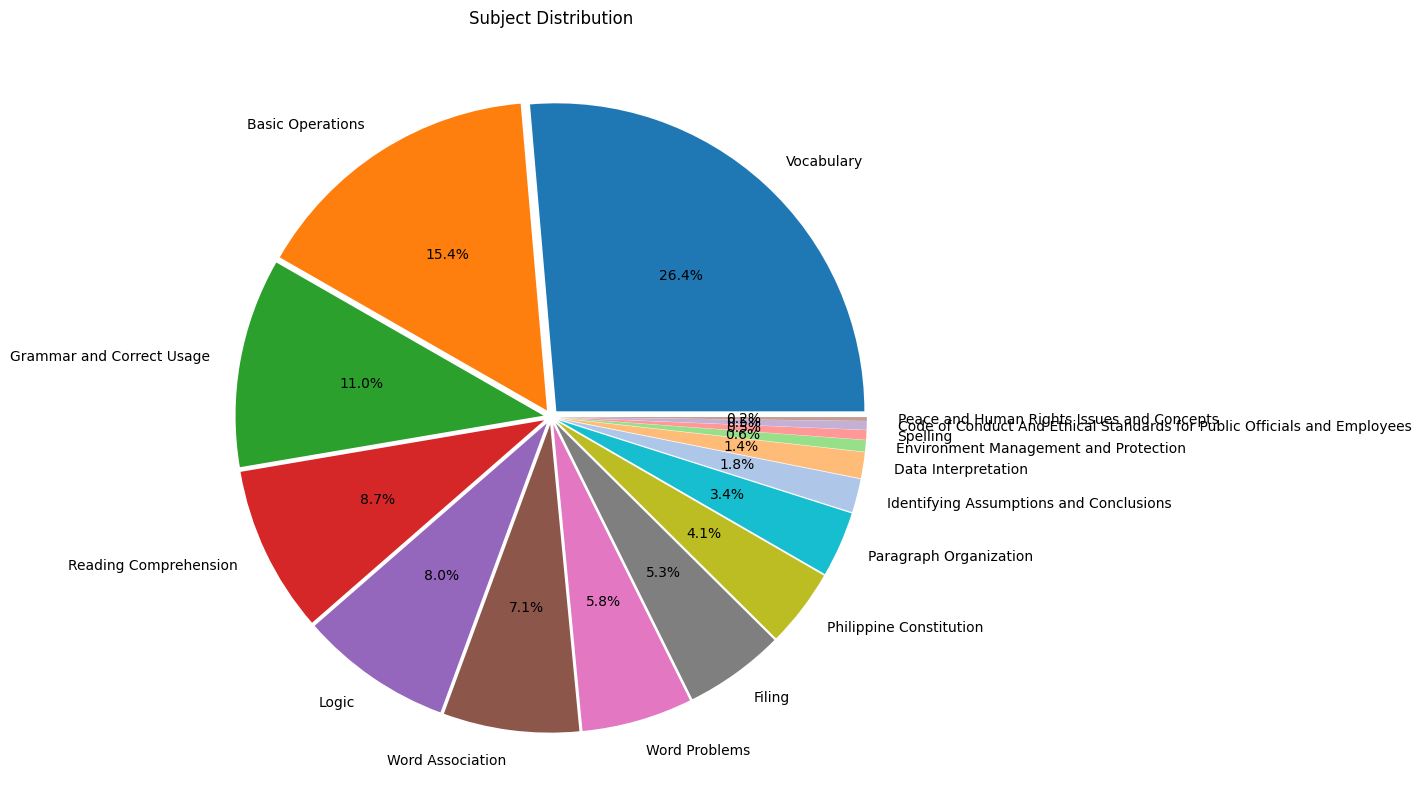

In [6]:
# Below is the code for plotting the df into a pie chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
          '#aec7e8', '#ffbb78', '#98df8a', '#ff9896', '#c5b0d5',
          '#c49c94']
explode = (0.025, 0.025, 0.025, 0.025, 0.025,
           0.025, 0.025, 0.025, 0.025, 0.025,
           0.025, 0.025, 0.025, 0.025, 0.025,
           0.025)

subject_dist_pie = subject_distribution.plot.pie(
    figsize=(10, 10),
    autopct='%1.1f%%',
    textprops={'fontsize': 10},
    colors=colors,
    explode = explode
)
subject_dist_pie.set_title('Subject Distribution')
subject_dist_pie.set_ylabel('')